<h1><center> OCT PROJET 


In [68]:
import os

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, savgol_filter

<h2> Normalisation des images

In [69]:

# --- Configuration ---
BASE_DATA_PATH = "./"
IMAGE_DIR = os.path.join(BASE_DATA_PATH, "Rad+cubeOD\OD\RAD")
OUTPUT_DIR = os.path.join(BASE_DATA_PATH, "rad_cropped") # Dossier pour les images recadrées
os.makedirs(OUTPUT_DIR, exist_ok=True)

CROP_X_START = 500 
CROP_Y_START = 20   
CROP_X_END = 1520   
CROP_Y_END = 450   


In [70]:

# --- Fonctions ---
def load_image(image_path):
    img = cv2.imread(image_path) # Charger en couleur au cas où pour l'affichage
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {image_path}")
    return img

def crop_image(image, x_start, y_start, x_end, y_end):
    if image is None:
        return None
    # S'assurer que les coordonnées sont valides
    h, w = image.shape[:2]
    x_s = max(0, x_start)
    y_s = max(0, y_start)
    x_e = min(w, x_end)
    y_e = min(h, y_end)

    if x_s >= x_e or y_s >= y_e:
        print(f"Erreur de recadrage: coordonnées invalides ({x_s},{y_s}) à ({x_e},{y_e}) pour une image de taille {w}x{h}")
        return image # ou None
    
    cropped = image[y_s:y_e, x_s:x_e]
    return cropped

def display_comparison(original_img, cropped_img, title_original="Originale", title_cropped="Recadrée"):
    if original_img is None or cropped_img is None:
        print("Une des images est None, impossible d'afficher.")
        return
        
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(title_cropped)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_image(image):
    
    plt.imshow(image, cmap='gray')
    plt.show()


In [71]:
def crop_bscan():
    '''  Recadre les B-scans d'une série d'images en fonction des coordonnées définies'''

    # --- Script Principal ---
    image_files = glob.glob(os.path.join(IMAGE_DIR, "*.tif")) # Ou .png, .jpg
    if not image_files:
        print(f"Aucun fichier .tif trouvé dans {IMAGE_DIR}. Vérifiez le chemin et l'extension.")
        exit()

    # Traiter une seule image pour tester les coordonnées de recadrage
    test_image_path = image_files[0] # Prendre la première image
    print(f"Traitement de l'image test: {test_image_path}")

    full_image = load_image(test_image_path)

    if full_image is not None:
        # Afficher les dimensions pour aider à déterminer les coordonnées
        print(f"Dimensions de l'image complète: {full_image.shape} (hauteur, largeur, canaux)")
        
        # Appliquer le recadrage
        # VOUS DEVEZ AJUSTER CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END
        cropped_bscan = crop_image(full_image, CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END)

        if cropped_bscan is not None and cropped_bscan.size > 0 :
            print(f"Dimensions de l'image recadrée: {cropped_bscan.shape}")
            display_comparison(full_image, cropped_bscan, 
                            title_original=f"Originale ({os.path.basename(test_image_path)})", 
                            title_cropped=f"B-Scan Recadré (Coords: x[{CROP_X_START}:{CROP_X_END}], y[{CROP_Y_START}:{CROP_Y_END}])")
            
            # Optionnel: Sauvegarder l'image recadrée
            # output_filename = os.path.join(OUTPUT_DIR, "cropped_" + os.path.basename(test_image_path))
            # cv2.imwrite(output_filename, cropped_bscan)
            # print(f"Image recadrée sauvegardée ici : {output_filename}")
        else:
            print("Le recadrage a produit une image vide ou None.")
            if full_image is not None:
                plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
                plt.title("Image originale (échec du recadrage)")
                plt.show()


    # Une fois que vous êtes satisfait des coordonnées pour UNE image,
    # vous pouvez décommenter cette boucle pour traiter toutes les images :

    print("\n--- Traitement de toutes les images ---")
    for img_path in image_files:
        print(f"Traitement de : {img_path}")
        current_full_image = load_image(img_path)
        if current_full_image is not None:
            current_cropped_bscan = crop_image(current_full_image, CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END)
            if current_cropped_bscan is not None and current_cropped_bscan.size > 0:
                output_filename = os.path.join(OUTPUT_DIR, "cropped_" + os.path.basename(img_path))
                # Convertir en niveaux de gris avant de sauvegarder si vous ne voulez que le B-scan en gris
                # current_cropped_bscan_gray = cv2.cvtColor(current_cropped_bscan, cv2.COLOR_BGR2GRAY)
                # cv2.imwrite(output_filename, current_cropped_bscan_gray)
                cv2.imwrite(output_filename, current_cropped_bscan) # Sauvegarde en couleur (ou comme l'original)
                print(f"  -> Sauvegardée : {output_filename}")
            else:
                print(f"  -> Échec du recadrage pour {img_path}")


<h1> Segmentation de la rétine

<h2> Décomposition en 3 méthodes différentes


Méthode n°1 : 
<br>-Prétraitement (par B-scan recadré) : Améliorer la qualité de l'image pour faciliter la segmentation.
<br>-Segmentation de l'ILM (Internal Limiting Membrane) : C'est la première interface hyper-réflective (brillante) en partant du vitré (la zone sombre en haut).
<br>-Segmentation de la Limite Externe du HRC (Hyper-Reflective Complex) : C'est une autre couche brillante, plus profonde que l'ILM. Sa position est souvent relative à l'ILM.
<br>-Post-traitement : Lisser les courbes segmentées, combler les petits trous.

In [72]:
def get_image_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.tif"))
    
            
            



def pre_filtrage(cropped_bscan):

    gray_bscan = cv2.cvtColor(cropped_bscan, cv2.COLOR_BGR2GRAY)

    # Filtre Gaussien
    blurred = cv2.GaussianBlur(gray_bscan, (5, 5), 0) # Ajustez la taille du noyau

    # Ou Filtre Médian (bon pour le bruit poivre et sel)
    blurred = cv2.medianBlur(gray_bscan, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(blurred)
    image_to_process = contrast_enhanced
    # Ou utiliser 'blurred' directement si le contraste est déjà bon
    return blurred


def segment_ilm_gradient_based(image_processed):
    ilm_line = np.zeros(image_processed.shape[1], dtype=int)
    # Réduire la zone de recherche pour l'ILM (par exemple, le tiers supérieur de l'image)
    search_roi_y_end = image_processed.shape[0] 

    for x in range(image_processed.shape[1]):
        column = image_processed[:search_roi_y_end, x]
        
        # Calculer le gradient vertical (différence simple ou Sobel)
        # grad_y = np.diff(column.astype(float)) # Simple diff, longueur N-1
        # Ou utiliser Sobel pour un gradient plus robuste
        sobel_y = cv2.Sobel(column, cv2.CV_64F, 0, 1, ksize=3) # Gradient en Y

        # Trouver le premier pic positif important
        # On cherche une transition sombre -> clair, donc un gradient positif important
        # (ou un pic négatif si on utilise diff et qu'on regarde la valeur d'avant)
        
        # Simplification: trouver le premier pixel au-dessus d'un seuil après lissage
        # Cette partie est très similaire à la méthode simple mais sur une image mieux préparée
        # et avec un ROI. Une vraie détection de pic de gradient serait mieux.
        
        # Pour une approche "premier pixel au-dessus d'un seuil dans ROI" (plus simple à coder ici)
        threshold_val = np.mean(column) + np.std(column) # Seuil adaptatif simple
        potential_points = np.where(column > threshold_val)[0]

        if len(potential_points) > 0:
            ilm_line[x] = potential_points[0]
        else:
            # Gérer le cas où rien n'est trouvé (ex: prendre la moyenne des voisins)
            if x > 0:
                ilm_line[x] = ilm_line[x-1] 
            else:
                ilm_line[x] = search_roi_y_end // 2 # Estimation grossière
    return ilm_line

def segment_hrc_relative_to_ilm(image_processed, ilm_line, search_offset=30, search_height=100):
    hrc_line = np.zeros(image_processed.shape[1], dtype=int)
    
    for x in range(image_processed.shape[1]):
        start_y_hrc = ilm_line[x] + search_offset
        end_y_hrc = min(image_processed.shape[0], start_y_hrc + search_height)
        
        if start_y_hrc >= end_y_hrc: # Si l'ILM est trop basse ou la bande trop petite
             if x > 0: hrc_line[x] = hrc_line[x-1]
             else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
             continue

        column_roi = image_processed[start_y_hrc:end_y_hrc, x]
        
        if column_roi.size == 0:
            if x > 0: hrc_line[x] = hrc_line[x-1]
            else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
            continue

        # Trouver le pixel le plus brillant dans ce ROI
        # Ceci est une simplification. Une détection de gradient ou de pic serait mieux.
        max_intensity_idx_in_roi = np.argmax(column_roi)
        hrc_line[x] = start_y_hrc + max_intensity_idx_in_roi
        
    return hrc_line


def post_filtrage(ilm_line, hrc_line):
    # Appliquer un filtre médian
    ilm_line_smooth = medfilt(ilm_line, kernel_size=15).astype(int) # Ajustez kernel_size
    hrc_line_smooth = medfilt(hrc_line, kernel_size=15).astype(int)

    # Ou un filtre Savitzky-Golay (bon pour préserver les pics tout en lissant)
    # ilm_line_smooth = savgol_filter(ilm_line, window_length=21, polyorder=3).astype(int) # Ajustez paramètres
    # hrc_line_smooth = savgol_filter(hrc_line, window_length=21, polyorder=3).astype(int)
    return ilm_line_smooth, hrc_line_smooth

def main_1(DIR):

    image_files = get_image_files(DIR)

    i=-1
    for image_path in image_files:
        image = load_image(image_path)
        i+=1
        
        pre_filtre = pre_filtrage(image)
        ilm = segment_ilm_gradient_based(pre_filtre)
        hrc = segment_hrc_relative_to_ilm(pre_filtre, ilm)

        ilm_smooth, hrc_smooth = post_filtrage(ilm, hrc)
        if i%10 ==0:
            print(i,image_path)
            print('\n\nimage originale')
            display_image(image)
            print('image pré-filtrée')
            display_image(pre_filtre)
            print('ILM détectée')
            plt.plot(ilm, label='ILM')
            plt.plot(hrc, label='HRC')
            print('image_pré-filtrée avec ILM et HRC')
            display_image(pre_filtre)
            plt.plot(ilm_smooth, label='ILM')
            plt.plot(hrc_smooth, label='HRC')
            print('image_pré-filtrée avec ILM et HRC lissées')
            display_image(pre_filtre)


            
    

Partie d'execution

0 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_000.tif


image originale


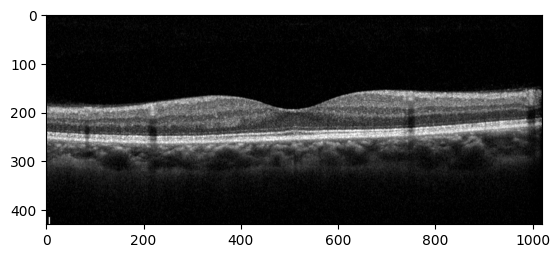

image pré-filtrée


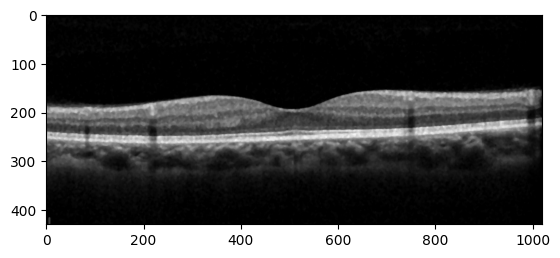

ILM détectée
image_pré-filtrée avec ILM et HRC


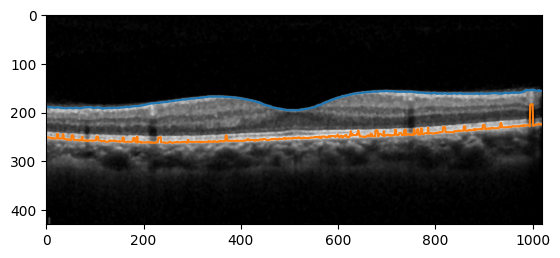

image_pré-filtrée avec ILM et HRC lissées


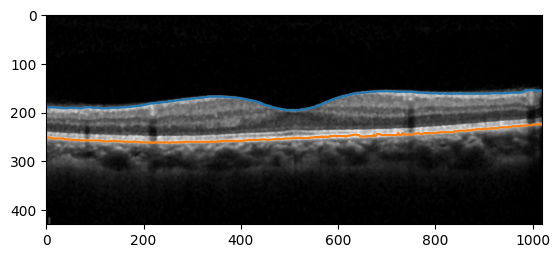

10 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_010.tif


image originale


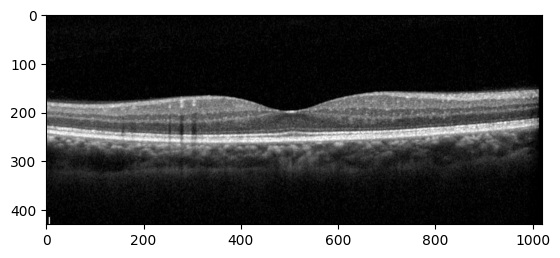

image pré-filtrée


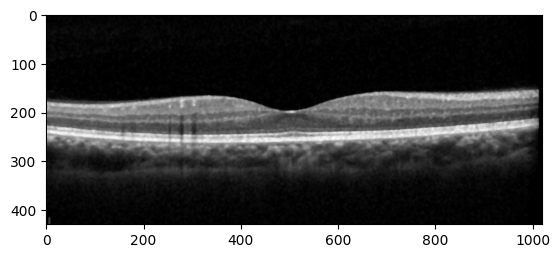

ILM détectée
image_pré-filtrée avec ILM et HRC


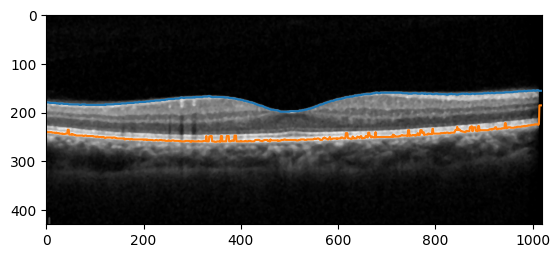

image_pré-filtrée avec ILM et HRC lissées


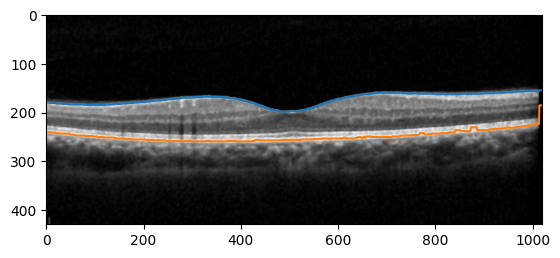

20 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_020.tif


image originale


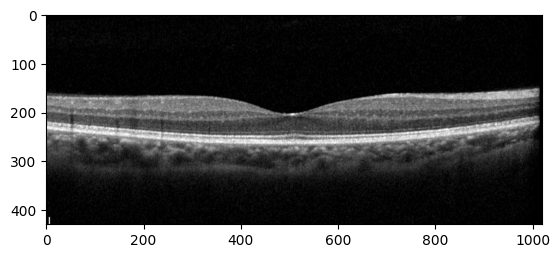

image pré-filtrée


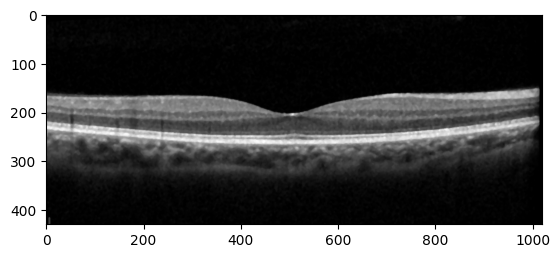

ILM détectée
image_pré-filtrée avec ILM et HRC


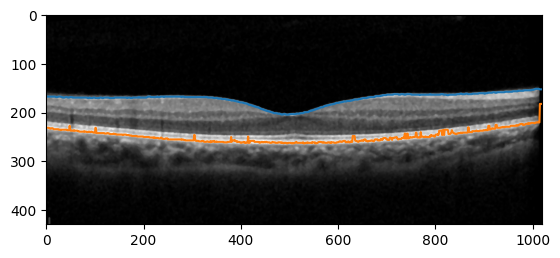

image_pré-filtrée avec ILM et HRC lissées


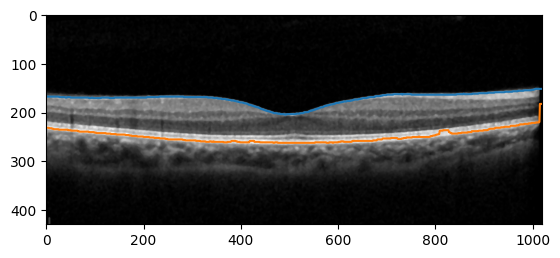

30 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_030.tif


image originale


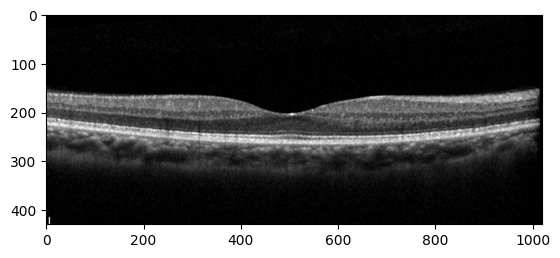

image pré-filtrée


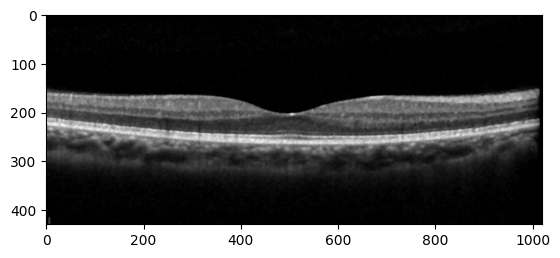

ILM détectée
image_pré-filtrée avec ILM et HRC


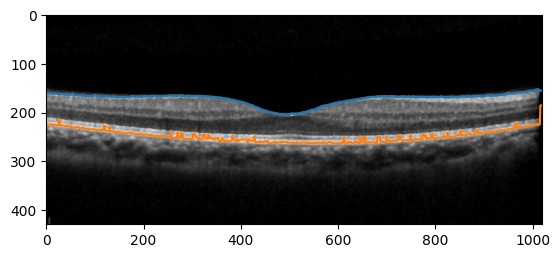

image_pré-filtrée avec ILM et HRC lissées


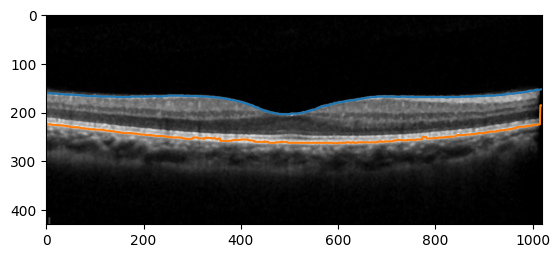

40 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_040.tif


image originale


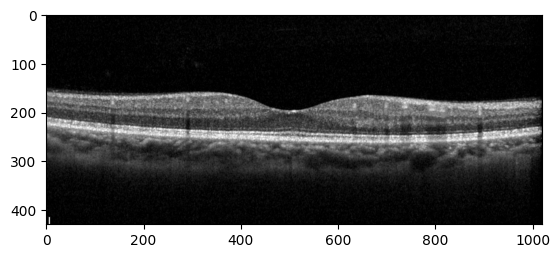

image pré-filtrée


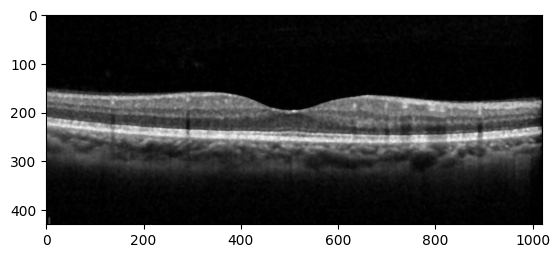

ILM détectée
image_pré-filtrée avec ILM et HRC


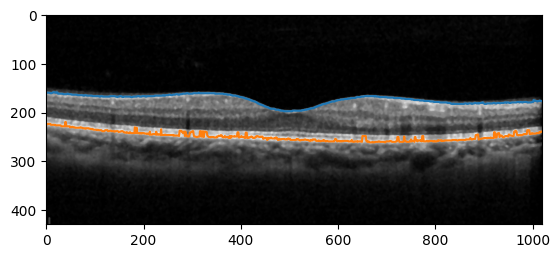

image_pré-filtrée avec ILM et HRC lissées


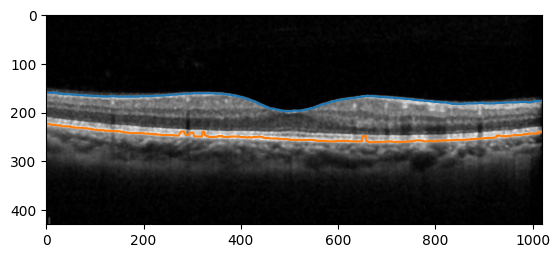

In [73]:
main_1(OUTPUT_DIR)

<h2> Méthode n°2 : Segmentation Basée sur les Graphes

L'idée est de transformer l'image en un graphe où les pixels sont des nœuds et les coûts des arêtes dépendent des gradients d'intensité. On cherche ensuite le chemin de coût minimal entre deux points (ou dans une certaine direction).